# Robustness Study:Card Card Fraud 


For this dataset, the aim is to predict whether credit card transaction is fraudulent or genuine. The original dataset is PCA transformed for privacy purpose. We drop the time information in our study https://www.kaggle.com/mlg-ulb/creditcardfraud.

First download the dataset and store it in your working directory.

## Librairies 

In [1]:
import os, sys, time
import numpy as np

import pandas as pd

In [2]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold

In [3]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [4]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [5]:
import pickle
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import EarlyStopping,LRScheduler,Checkpoint, TrainEndCheckpoint, EpochScoring
from skorch.dataset import Dataset
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
sys.path.append("../")
from sramodels.SRAModels import TabSRALinearClassifier,InputShapeSetterTabSRA,LinearClassifier

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb

In [ ]:
import shap

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor


In [7]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

## Data loading, preprocessing and Split

In [8]:
data_path = '../ESANN_XKDD/Datasets/'
data = pd.read_csv(data_path+'creditcard.csv')
data.drop('Time', axis=1, inplace=True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
data.Class.mean()

0.001727485630620034

### Preprocessing 

In [10]:
data_copy = data.copy()

In [11]:
feature_names = list(data.columns)
feature_names.remove('Class')

### Split 

In [12]:
k =5
Sf= StratifiedKFold(n_splits=k, shuffle=True, random_state= 42)
#datasets = [(X[train_index], X[test_index],y[train_index], y[test_index]) for train_index,test_index in Sf.split(X, y) ]
datasets_raw = [(data.iloc[train_index], data.iloc[test_index]) for train_index,test_index in Sf.split(data, data.Class.values) ]
data_train_df,data_test_df = datasets_raw[0]

In [13]:
data_train_df,data_test_df = datasets_raw[0]

In [14]:
X_train_, X_test_, Y_train_, Y_test_ = data_train_df[feature_names], data_test_df[feature_names],data_train_df.Class.values,data_test_df.Class.values

In [15]:
set_config(transform_output="pandas")
processor =  StandardScaler()

In [16]:
X_train_ = processor.fit_transform(X_train_)
X_test_ = processor.transform(X_test_)

### Correlation visualization (map)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [18]:
X_train_tmp = X_train_.copy()
X_train_tmp['y'] = Y_train_

/tmp/ipykernel_13855/1798339133.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


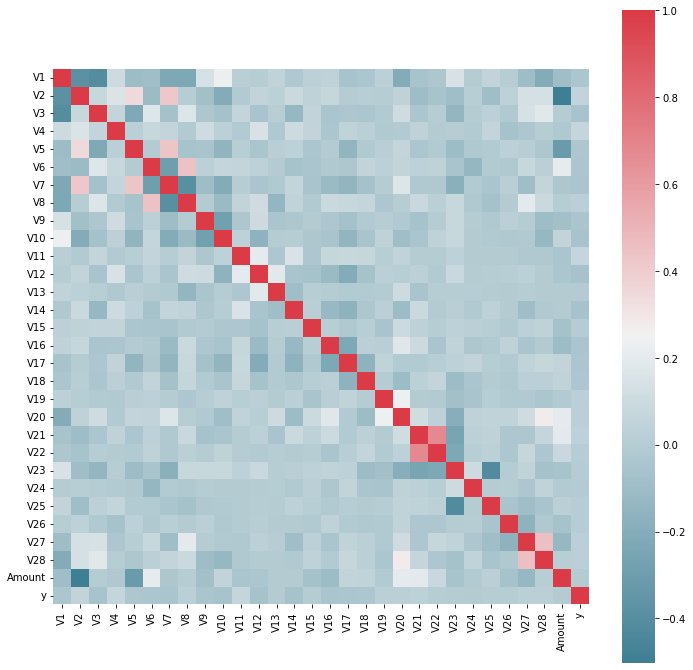

In [19]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 12))
tmp = X_train_tmp.astype(float) 
corr = tmp.corr(method='spearman')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

/tmp/ipykernel_13855/2226804073.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


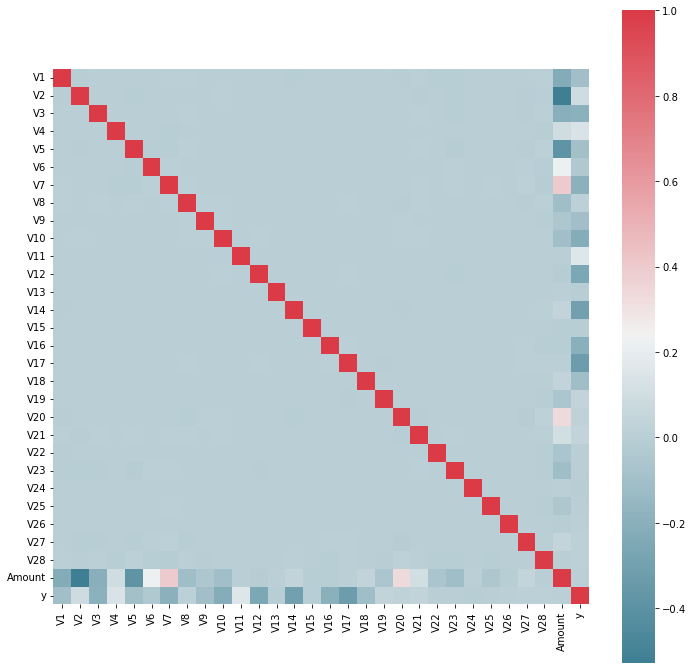

In [20]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 12))
tmp = X_train_tmp.astype(float) 
corr = tmp.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

## Model

### Linear  

In [19]:
#valid_loss
other_params_linear = {"module__bias":True,
                "optimizer__lr":0.005269,
                "optimizer__weight_decay":0.000072,
                "random_state":42,
                "criterion": nn.BCEWithLogitsLoss,
                "module__negative_indice":None,
                "module__positive_indice":None,
                "max_epochs":100,
                "batch_size":2048,
                "device":'cuda'#change the device in 'cpu' if there is no GPU
               }
scoring = EpochScoring(scoring='average_precision',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=False)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=10,load_best=True,lower_is_better=False, threshold=0.0001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=5, min_lr=2e-5,factor=0.2, verbose=1)
call_b = [scoring, setter, early_stop, lr_scheduler]

In [22]:
Y_test_.shape

(56962,)

In [23]:
%%time
valid_dataset = Dataset(X_test_.values.astype(np.float32),Y_test_.astype(np.float32))
LR = LinearClassifier(**other_params_linear,train_split = predefined_split(valid_dataset),callbacks = call_b)#,
_ = LR.fit(X_train_.values.astype(np.float32),Y_train_.astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    average_precision    train_loss    valid_acc    valid_loss     dur
-------  -------------------  ------------  -----------  ------------  ------
      1               0.6704        0.5015       0.9992        0.3963  1.8172
      2               0.6365        0.3265       0.9992        0.2682  1.2255
      3               0.6271        0.2260       0.9992        0.1918  1.3348
      4               0.6259        0.1649       0.9992        0.1437  1.3098
      5               0.6390        0.1255       0.9992        0.1117  1.3540
      6               0.6489        0.0986       0.9992        0.0886  1.2606
      7               0.6991        0.0791       0.9992        0.0716  1.2962
      8               0.6940        0.0649       0.9992        0.0594  1.2575
      9               0.7041        0.0544       0.9993   

In [25]:
len(feature_names)

29

In [21]:
Coef  = pd.DataFrame(LR.get_weights()[0])
Coef = Coef
Coef.columns=feature_names
Coef

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.07177,0.019077,-0.015189,0.228679,0.103202,-0.050416,-0.083417,-0.134857,-0.13168,-0.224736,0.114774,-0.174018,-0.064002,-0.379879,-0.001001,-0.11745,-0.075411,-0.002392,0.018217,-0.038823,0.059589,0.05622,0.007327,0.000492,-0.030213,0.020714,-0.031456,0.022659,0.095045


In [22]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
pred_lr = LR.predict_proba(X_test_.values.astype(np.float32))[:,1]

best_aucroc_lr = roc_auc_score(Y_test_, pred_lr) 
best_aurpr_lr = average_precision_score(Y_test_, pred_lr) 
print(f"--AUCROC perf = {best_aucroc_lr} -- AUCPR perf = {best_aurpr_lr}")

--AUCROC perf = 0.9833274624087631 -- AUCPR perf = 0.7344657424704154


### TabSRA  

In [23]:
#valid_loss
other_params = {"module__encoder_bias":True,
                "module__classifier_bias":True,
                "module__n_head":2,
                "module__dim_head":4,
                "module__n_hidden_encoder":1,
                "module__dropout_rate":0.2,
                "optimizer__lr":0.0006750277604651748,
                "optimizer__weight_decay":2.1563909801506647e-05,
                "random_state":42,
                "criterion": nn.BCEWithLogitsLoss,
                "module__negative_indice":None,
                "module__positive_indice": None,
                "max_epochs":800,
                "batch_size":2048,
                "device":'cuda'#change the device in 'cpu' if there is no GPU
               }
scoring = EpochScoring(scoring='average_precision',lower_is_better=False)
setter = InputShapeSetterTabSRA(regression=False)
early_stop = EarlyStopping(monitor=scoring.scoring, patience=50,load_best=True,lower_is_better=False, threshold=0.0001,threshold_mode='abs')
lr_scheduler = LRScheduler(policy=ReduceLROnPlateau, patience=25, min_lr=2e-5,factor=0.2, verbose=1)
call_b = [scoring, setter, early_stop, lr_scheduler]

In [38]:
%%time
valid_dataset = Dataset(X_test_.values.astype(np.float32),Y_test_.astype(np.float32))
TabSRA = TabSRALinearClassifier(**other_params,train_split = predefined_split(valid_dataset),callbacks = call_b)#,
_ = TabSRA.fit(X_train_.values.astype(np.float32),Y_train_.astype(np.float32))

Re-initializing module because the following parameters were re-set: module__dim_input, module__dim_output.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    average_precision    train_loss    valid_acc    valid_loss     dur
-------  -------------------  ------------  -----------  ------------  ------
      1               0.3762        0.5403       0.9988        0.3451  1.5378
      2               0.4896        0.1901       0.9989        0.0896  1.4672
      3               0.6187        0.0647       0.9990        0.0419  1.4893
      4               0.6730        0.0362       0.9991        0.0266  1.5036
      5               0.6934        0.0249       0.9992        0.0196  1.4541
      6               0.7136        0.0190       0.9993        0.0156  1.4701
      7               0.7289        0.0154       0.9993        0.0130  1.4424
      8               0.7359        0.0132       0.9994        0.0113  1.5338
      9               0.7280        0.0115       0.9993   

In [26]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
pred_tabsra = TabSRA.predict_proba(X_test_.values.astype(np.float32))[:,1]

best_aucroc = roc_auc_score(Y_test_, pred_tabsra) 
best_aurpr = average_precision_score(Y_test_, pred_tabsra) 
print(f"--AUCROC perf = {best_aucroc} -- AUCPR perf = {best_aurpr}")

--AUCROC perf = 0.9532959512647534 -- AUCPR perf = 0.8435589163670087


In [27]:
Coef  = pd.DataFrame(TabSRA.get_weights()[0])
Coef = Coef.T
Coef.columns=feature_names
Coef

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.968044,0.994672,-1.190278,1.178692,-1.210035,1.605707,-1.309882,-0.441466,0.758051,-0.688957,-1.318433,0.9174,-0.665858,-0.851778,-1.415205,-0.900732,1.124458,-1.101885,0.768821,-0.584868,1.01632,-1.224642,0.447629,0.994145,1.379348,-1.224864,0.257821,0.100005,-0.430562


### XGBoost

In [28]:
from xgboost import XGBClassifier
import xgboost as xgb

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [29]:
static_params = {
                 'random_state':42,
                 'objective': 'binary:logistic',
                 'n_jobs': -1,
                 #'base_score':y.mean()

}

params = {'eta': 0.08507671904675652, 'max_depth': 5, 'colsample_bytree': 1.0, 'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 2}



params.update(static_params)

In [30]:
model_xgb = XGBClassifier(**params)

In [31]:
%%time
eval_set = [(X_train_.values, Y_train_), (X_test_.values, Y_test_)] #(X_train, Y_train[:,1]), 
model_xgb.fit(X_train_.values, Y_train_, eval_metric=['aucpr'], eval_set=eval_set, verbose=0,early_stopping_rounds=50)

/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 8min 39s, sys: 2.02 s, total: 8min 41s
Wall time: 33.5 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eta=0.08507671904675652, gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.0850767195, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [32]:
pred_xgb = model_xgb.predict_proba(X_test_)[:,1]
best_aucroc_xgb = roc_auc_score(Y_test_, pred_xgb) 
best_aurpr_xgb = average_precision_score(Y_test_, pred_xgb) 
print(f"--AUCROC perf = {best_aucroc_xgb} -- AUCPR perf = {best_aurpr_xgb}")

--AUCROC perf = 0.9845643534158034 -- AUCPR perf = 0.8481114604641594


### EBM

In [34]:
%%time
EBM_S = ExplainableBoostingClassifier(interactions=0,max_rounds=2500,early_stopping_rounds=50,validation_size=0)#max_bins=256#,inner_bags=100,outer_bags=100 # 10
EBM_S.fit(X_train_, Y_train_)

/home/kodjo/anaconda3/lib/python3.9/site-packages/interpret/glassbox/_ebm/_ebm.py:426: UserWarning: If validation_size is 0, the outer_bags have no purpose. Set outer_bags=1 to remove this warning.
  warn(


CPU times: user 8.91 s, sys: 424 ms, total: 9.34 s
Wall time: 1min 27s


ExplainableBoostingClassifier(interactions=0, max_rounds=2500,
                              validation_size=0)

In [35]:
pred_ebm_s = EBM_S.predict_proba(X_test_)[:,1]
best_aucroc_ebm_s = roc_auc_score(Y_test_, pred_ebm_s) 
best_aurpr_ebm_s = average_precision_score(Y_test_, pred_ebm_s) 
print(f"--AUCROC perf = {best_aucroc_ebm_s} -- AUCPR perf = {best_aurpr_ebm_s}")

--AUCROC perf = 0.9724736239165658 -- AUCPR perf = 0.8307529781109011


In [36]:
%%time
EBM = ExplainableBoostingClassifier(interactions=10,max_rounds=2500,early_stopping_rounds=50,n_jobs=-1,validation_size=0)#max_bins=256#,inner_bags=100,outer_bags=100 # 10
EBM.fit(X_train_, Y_train_)

/home/kodjo/anaconda3/lib/python3.9/site-packages/interpret/glassbox/_ebm/_ebm.py:426: UserWarning: If validation_size is 0, the outer_bags have no purpose. Set outer_bags=1 to remove this warning.
  warn(


CPU times: user 10.2 s, sys: 56.3 ms, total: 10.3 s
Wall time: 1min 56s


ExplainableBoostingClassifier(max_rounds=2500, n_jobs=-1, validation_size=0)

In [37]:
pred_ebm = EBM.predict_proba(X_test_)[:,1]
best_aucroc_ebm = roc_auc_score(Y_test_, pred_ebm) 
best_aurpr_ebm = average_precision_score(Y_test_, pred_ebm) 
print(f"--AUCROC perf = {best_aucroc_ebm} -- AUCPR perf = {best_aurpr_ebm}")

--AUCROC perf = 0.9693344112386372 -- AUCPR perf = 0.834278608545162


## Explanations

In [43]:
%%time
attributions_linear = pd.DataFrame(LR.get_feature_attribution(X_test_.values))
attributions_linear.columns = feature_names
attributions_linear['pred_proba'] = pred_lr
attributions_linear['label'] = Y_test_

CPU times: user 239 ms, sys: 7.8 ms, total: 246 ms
Wall time: 18.5 ms


In [44]:
%%time
attributions_tabsra = pd.DataFrame(TabSRA.get_feature_attribution(X_test_.values))
attributions_tabsra.columns = feature_names
attributions_tabsra['pred_proba'] = pred_tabsra
attributions_tabsra['label'] = Y_test_

CPU times: user 265 ms, sys: 4.08 ms, total: 270 ms
Wall time: 23.3 ms


In [45]:
%%time
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred_proba'] = pred_xgb
attributions_xgb['label'] = Y_test_

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 44.7 s, sys: 56.2 ms, total: 44.7 s
Wall time: 3.16 s


In [46]:
def get_feature_attribution_EBM(model, X_test):
    tmp  = model.explain_local(X_test)
    df_EBM = []
    for i in range(len(X_test)):
        df_EBM.append(tmp.data(i)['scores'])
    df_EBM = pd.DataFrame(df_EBM)
    df_EBM.columns = tmp.data(0)['names']
    return df_EBM

In [47]:
attributions_EBM_S = get_feature_attribution_EBM(EBM_S, X_test_)


In [48]:
%%time
attributions_EBM_S = get_feature_attribution_EBM(EBM_S, X_test_)
feature_names_EBM_S = list(attributions_EBM_S.columns)
attributions_EBM_S['pred_proba'] = pred_ebm_s
attributions_EBM_S['label'] = Y_test_

CPU times: user 1.49 s, sys: 48 ms, total: 1.53 s
Wall time: 1.53 s


In [49]:
%%time
attributions_EBM = get_feature_attribution_EBM(EBM, X_test_)
feature_names_EBM = list(attributions_EBM.columns)
attributions_EBM['pred_proba'] = pred_ebm
attributions_EBM['label'] = Y_test_

CPU times: user 1.98 s, sys: 48 ms, total: 2.03 s
Wall time: 2.02 s


### Stability

In [51]:
np.random.seed(42)
random_ = np.random.randn(len(X_test_))
sample_condition = np.where(random_>1.7, True, False)
sample_condition.sum()

2533

In [52]:
X_test_tmp = X_test_[sample_condition]

In [53]:
alpha_stp = 1e-3
n_pertub = 100
epsilon_min = 1e-3
n_features = len(feature_names)

In [56]:
np.random.seed(42)
tmp_x =np.random.normal(0,1*alpha_stp, n_features*n_pertub).reshape(n_pertub,n_features)
rapport_denom  = np.linalg.norm(tmp_x,ord=2, axis=1)
n_point = len(X_test_tmp)

In [57]:
X_test_tmp_np   = X_test_tmp[feature_names].values
X_explain_lr,y_explain_lr = attributions_linear[sample_condition][feature_names].values, attributions_linear[sample_condition].pred_proba.values
X_explain_tabsra,y_explain_tabsra = attributions_tabsra[sample_condition][feature_names].values, attributions_tabsra[sample_condition].pred_proba.values
X_explain_xgb,y_explain_xgb = attributions_xgb[sample_condition][feature_names].values, attributions_xgb[sample_condition].pred_proba.values
X_explain_EBM_S,y_explain_EBM_S = attributions_EBM_S[sample_condition][feature_names_EBM_S].values, attributions_EBM_S[sample_condition].pred_proba.values
X_explain_EBM,y_explain_EBM= attributions_EBM[sample_condition][feature_names_EBM].values, attributions_EBM[sample_condition].pred_proba.values


In [58]:
time_lr =[]
for i in range(10):
    start_ = time.time()
    relative_norm_lr = np.zeros(n_point)
    relative_pred_lr = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x
        X_new = torch.Tensor(X_new_np)

        y_pred_linear = LR.predict_proba(X_new)[:,1]
        X_explain_new_ = np.linalg.norm(X_explain_lr[i] - LR.get_feature_attribution(X_new),ord=2,axis=1)

        tmp = np.abs(y_explain_lr[i]-y_pred_linear)
        ind_adversial = np.argmax(tmp)
        relative_pred_lr[i] = tmp[ind_adversial]
        relative_norm_lr[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
    time_lr.append(time.time()-start_)

In [59]:
np.mean(time_lr),np.std(time_lr)

(2.1203370094299316e+00, 0.03181506367914166)

In [60]:
time_tabsra =[]
for i in range(10):
    start_ = time.time()
    relative_norm_tabsra = np.zeros(n_point)
    relative_pred_tabsra = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x
        X_new = torch.Tensor(X_new_np)

        y_pred_tabsra = TabSRA.predict_proba(X_new)[:,1]
        X_explain_new_ = np.linalg.norm(X_explain_tabsra[i] - TabSRA.get_feature_attribution(X_new),ord=2,axis=1)

        tmp = np.abs(y_explain_tabsra[i]-y_pred_tabsra)
        ind_adversial = np.argmax(tmp)
        relative_pred_tabsra[i] = tmp[ind_adversial]
        relative_norm_tabsra[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
    time_tabsra.append(time.time()-start_)

In [61]:
np.mean(time_tabsra),np.std(time_tabsra)

(5.1221542119979855, 0.12985935867640375)

In [62]:
time_xgb =[]
for i in range(10):
    start_ = time.time()
    relative_norm_xgb = np.zeros(n_point)
    relative_pred_xgb = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x


        y_pred_xgb = model_xgb.predict_proba(X_new_np)[:,1]
        X_explain_new_ = np.linalg.norm(X_explain_xgb[i] - explainer(X_new_np).values,ord=2,axis=1)

        tmp = np.abs(y_explain_xgb[i]-y_pred_xgb)
        ind_adversial = np.argmax(tmp)
        relative_pred_xgb[i] = tmp[ind_adversial]
        relative_norm_xgb[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
    time_xgb.append(time.time()-start_)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [63]:
np.mean(time_xgb),np.std(time_xgb)

(24.203415441513062, 1.214801005924038)

In [64]:
time_EBM_S =[]
for i in range(10):
    start_ = time.time()
    relative_norm_EBM_S = np.zeros(n_point)
    relative_pred_EBM_S = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x
        X_new_df = pd.DataFrame(X_new_np,columns=feature_names)

        y_pred_EBM_S = EBM_S.predict_proba(X_new_np)[:,1]
        X_explain_EBM_S_ = np.linalg.norm(X_explain_EBM_S[i] - get_feature_attribution_EBM(EBM_S, X_new_df).values,ord=2,axis=1)

        tmp = np.abs(y_explain_EBM_S[i]-y_pred_EBM_S)
        ind_adversial = np.argmax(tmp)
        relative_pred_EBM_S[i] = tmp[ind_adversial]
        relative_norm_EBM_S[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
time_EBM_S.append(time.time()-start_)

In [65]:
np.mean(time_EBM_S),np.std(time_EBM_S)

(18.110591888427734, 0.0)

In [66]:
time_EBM =[]
for i in range(10):
    start_ = time.time()
    relative_norm_EBM = np.zeros(n_point)
    relative_pred_EBM = np.zeros(n_point)
    for i in range(n_point):
        #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
        X_new_np = X_test_tmp_np[i]+tmp_x
        X_new_df = pd.DataFrame(X_new_np,columns=feature_names)

        y_pred_EBM = EBM.predict_proba(X_new_np)[:,1]
        X_explain_EBM_ = np.linalg.norm(X_explain_EBM[i] - get_feature_attribution_EBM(EBM, X_new_df).values,ord=2,axis=1)

        tmp = np.abs(y_explain_EBM[i]-y_pred_EBM)
        ind_adversial = np.argmax(tmp)
        relative_pred_EBM[i] = tmp[ind_adversial]
        relative_norm_EBM[i] =  (X_explain_new_/rapport_denom)[ind_adversial]
    time_EBM.append(time.time()-start_)       

In [68]:
np.mean(time_EBM),np.std(time_EBM)

(19.939333486557008, 0.4431550591672805)

In [69]:
df_classic_expl = pd.DataFrame()

df_classic_expl["LR"] = relative_norm_lr
df_classic_expl["TabSRALinear"] = relative_norm_tabsra
df_classic_expl["EBM"] = relative_norm_EBM
df_classic_expl["EBM_S"] = relative_norm_EBM_S
df_classic_expl["XGBoost+TreeSHAP"] = relative_norm_xgb

In [70]:
df_classic_output = pd.DataFrame()
df_classic_output["LR"] = relative_pred_lr
df_classic_output["TabSRALinear"] = relative_pred_tabsra
df_classic_output["EBM"] = relative_pred_EBM
df_classic_output["EBM_S"] = relative_pred_EBM_S
df_classic_output["XGBoost+TreeSHAP"] = relative_pred_xgb

In [71]:
df_classic_expl.head()

,LR,TabSRALinear,EBM,EBM_S,XGBoost+TreeSHAP
0,0.134227,0.918682,5.987371,5.987371,102.398034
1,0.134229,0.939559,0.000000,5.987371,13.522273
2,0.134226,0.811474,0.000000,0.000000,48.322458
3,0.134225,0.984512,0.000000,0.000000,55.420292
4,0.134227,1.382372,6.082023,6.082023,25.610682


In [77]:
len(df_classic_expl),len(X_test_)

(2533, 56962)

In [78]:
df_classic_expl.columns = ['LR', 'SRA', 'EBM', 'EBM_S', 'XGB_SHAP']

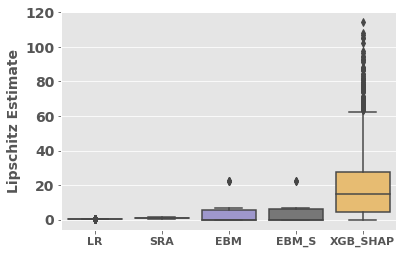

In [79]:
sns.boxplot(data=df_classic_expl)
plt.ylabel("Lipschitz Estimate",weight = 'bold',fontsize=14)
plt.xticks(weight = 'bold',fontsize=11,rotation=0)
plt.yticks(weight = 'bold',fontsize=14)
plt.savefig('Stability_CardFraud_Split0_hideen1_1E_3.png')
plt.show()

In [80]:
df_classic_output.columns = ['LR', 'SRA', 'EBM', 'EBM_S', 'XGB_SHAP']

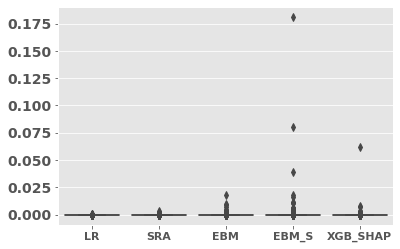

In [81]:
sns.boxplot(data=df_classic_output)
#plt.ylabel("Output Change",weight = 'bold',fontsize=14)
plt.xticks(weight = 'bold',fontsize=11,rotation=0)
plt.yticks(weight = 'bold',fontsize=14)
plt.savefig('Stability_OutputChange_CardFraud_Split0_hideen1_1E_3.png')
plt.show()